In [ ]:
# 한국어 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 런타임 -> 런타임 다시 시작을 실행해주세요

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 3s (3,834 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and di

In [ ]:
!pip install transformers==4.18.0
!pip install datasets==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 81.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 95.9 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=71377cbf4436338f8014374168c8868a37a948f09d33445f14f38f856b7072bc
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.9

이번 실습에서는 Semi Supervised Learning 방법론 중 Consistency Regularization을 다뤄보겠습니다.
구체적으로 Self Consistency 방법론 중 하나인 UDA를 직접 실습해보도록 하겠습니다.
UDA는 수업에서 다룬 바와 같이 1) 레이블이 있는 데이터에 대한 지도학습과 2) 레이블이 없는 데이터에 대해 Augmentation을 통한 비지도학습으로 구성되어 있습니다.

# 0. Data & Preprocessing

이번 실습에서는 이진분류 문제를 다뤄보도록 하겠습니다.
활용할 데이터셋은 개와 음식 사진을 구별하는 데이터셋입니다.
머핀이나 치킨과 비슷하게 생긴 강아지 사진과 실제 머핀 및 치킨 사진을 구별하는 문제입니다.

## 0-1. Data 다운로드 및 예시
온라인 상에 공개되어 있는 데이터를 쉽게 다운받을 수 있도록 도와주는 HuggingFace 사의 Datasets 라이브러리를 이용하여 데이터를 다운로드 받습니다.
(https://huggingface.co/datasets/sasha/dog-food)

In [ ]:
import torch
import torch.utils.checkpoint
from torch import Tensor, nn
from torch.nn import CrossEntropyLoss
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomVerticalFlip, ToTensor

from transformers import AutoFeatureExtractor, AutoConfig, AutoModel
from datasets import load_dataset


from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm

import numpy as np
import gc

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 시드 고정
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [ ]:
## 데이터 다운로드 시 1분 이내의 시간이 소요됩니다.
dataset = load_dataset("sasha/dog-food")

## 해당 데이터셋은 Train/Test로 구성되어 있습니다. 이를 우선 분리하겠습니다.
train_dataset = list(dataset["train"])
test_dataset = list(dataset["test"])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sasha___parquet/sasha--dog-food-ec42a61d5519cc88/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 1.0, '머핀 이미지')

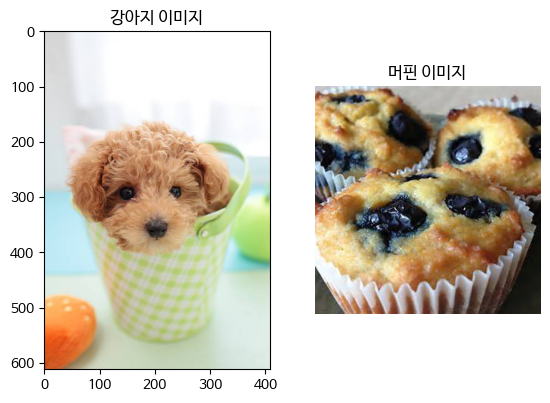

In [ ]:
## 실제 강아지와 음식 사진 예시입니다.
### 강아지 사진은 푸들이 주를 이루고, 음식 사진은 머핀과 치킨이 주를 이루게 됩니다.
plt.subplot(1,2,1)
plt.imshow(train_dataset[3]['image'])
plt.title("강아지 이미지")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_dataset[-2]['image'])
plt.axis('off')
plt.title("머핀 이미지")


우리가 보는 이미지는 모두 행렬 형식으로 구성되어, 컴퓨터에서 처리됩니다.
(높이, 너비, RGB) 형태의 행렬로 구성되어 있습니다.

In [ ]:
dog_arr = np.array(train_dataset[3]['image'])
print(f"강아지 이미지의 행렬 형태 : {dog_arr.shape}")
print(">>> 강아지 이미지의 Red 채널의 픽셀값")
print(dog_arr[:,:,0])

강아지 이미지의 행렬 형태 : (612, 408, 3)
>>> 강아지 이미지의 Red 채널의 픽셀값
[[212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 [212 212 212 ... 255 255 255]
 ...
 [187 190 195 ... 221 222 222]
 [192 195 199 ... 221 222 222]
 [195 198 201 ... 221 222 222]]


## 0-2. 모델 및 전처리 파이프라인 다운로드
기본 모델로 사전학습된 ResNet-50(https://arxiv.org/abs/1512.03385)을 사용하겠습니다.
해당 모델은 2015년에 공개된 이미지 분류 모델로서, 현재까지 대부분의 이미지/언어 모델의 기본적인 원리를 구성하고 있습니다.

모델과 모델 입력 전처리를 위한 파이프라인은 HuggingFace 사의 transformers 라이브러리를 이용하여 다운로드하겠습니다.

In [ ]:
# 사용할 모델 역시 이전과 동일한 ResNet50의 구조를 그대로 사용하겠습니다.
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
config = AutoConfig.from_pretrained("microsoft/resnet-50", output_hidden_states=True)
model = AutoModel.from_config(config)

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

In [ ]:
"""
사전학습된 이미지 모델들은 각 모델마다 제각기 다른 전처리 파이프라인을 가지고 있습니다.
이는 사전학습 시 사용된 정보가 다르기 때문에 발생하는 현상입니다.
1. 학습 때 사용된 이미지의 크기
2. 학습 때 사용된 이미지의 채널 수
3. 학습 때 사용된 이미지의 픽셀값 범위
4. 학습 때 사용된 이미지의 Normalization 방법

등 다양한 요소가 영향을 미치게 됩니다. 사전학습된 이미지 모델을 활용할 경우 이러한 요소를 고려하여 전처리를 진행해야 합니다.
"""
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



## 0-3. 전처리 및 모델 출력값 확인

전처리 전 이미지의 크기 : (612, 408, 3)
전처리 후 이미지의 크기 : (224, 224, 3)


Text(0.5, 1.0, 'Preprocessed Image')

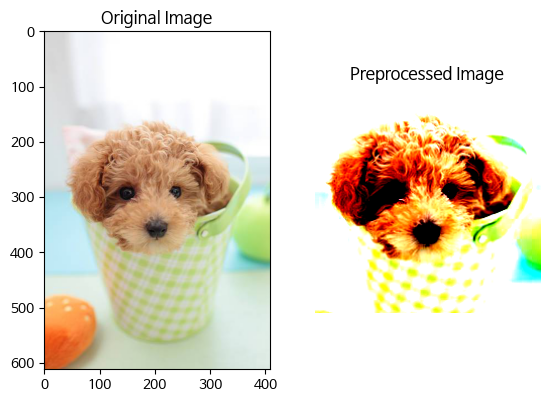

In [ ]:
"""
전처리를 거친 이미지는 다음과 같이 변환됩니다.
"""

original_image = train_dataset[3]['image']
preprocessed_image = feature_extractor(images=original_image)['pixel_values'][0].transpose(1,2,0)
print(f"전처리 전 이미지의 크기 : {np.array(original_image).shape}")
print(f"전처리 후 이미지의 크기 : {preprocessed_image.shape}")

"""
시각화하여 확인해보면 다음과 같습니다.
"""

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(preprocessed_image)
plt.axis('off')
plt.title("Preprocessed Image")


모델 입력 시 1) 이미지의 크기를 일정하도록 이미지 중앙부분을 중심으로 자르고 2) 입력값의 범위를 일정하도록 맞춰주는 작업을 수행하게 됩니다.
그 결과 위와 같이 원본 이미지와 다소 다른 모습을 확인할 수 있습니다.

이제 위와 같은 전처리를 거친 이미지를 모델 입력으로 사용 시 출력을 확인해보겠습니다.

In [ ]:
inputs = feature_extractor(images=original_image, return_tensors="pt") # 모델이 입력으로 받을 수 있는 Pytorch Tensor 형태로 변환합니다.
with torch.no_grad():
    outputs = model(**inputs) # 모델이 입력된 이미지에 대해 벡터 형태의 특징을 추출합니다.

print(f"특징 벡터의 형태 : {outputs.last_hidden_state.shape}")
last_hidden_states = outputs.pooler_output # 모델이 생성한 특징 벡터를 압축하여 2048차원의 벡터로 변환합니다.
print(f"압축된 특징 벡터의 형태 : {last_hidden_states.shape}")

특징 벡터의 형태 : torch.Size([1, 2048, 7, 7])
압축된 특징 벡터의 형태 : torch.Size([1, 2048, 1, 1])


In [ ]:
class ResNetForImageClassification(nn.Module) :
    def __init__(self, feature_extractor, num_labels=2) :
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(self.feature_extractor.config.hidden_sizes[-1], num_labels)
        self.softmax = nn.Softmax(dim=-1)
        self.num_labels = num_labels

        self.id2label = {0 : "강아지", 1 : "음식"}

    def forward(self, pixel_values, labels=None) :
        pixel_values = self.feature_extractor(pixel_values)
        logits = self.classifier(pixel_values.pooler_output.squeeze())
        logits = self.softmax(logits,)

        loss = None
        preds = torch.argmax(logits, dim=-1).reshape(-1, 1)
        if labels is not None :
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))


        return {
            "모델의 예측 확률" : logits,
            "loss" : loss,
            "logits" : logits,
            "모델의 정확도" : (sum(preds == labels.reshape(-1, 1))/len(labels)).item() if labels is not None else None,
            "모델의 예측값" : {'text' : [self.id2label[pred.item()] for pred in preds], 'id' : preds}
            }

>> 입력 이미지의 형태 : torch.Size([1, 3, 224, 224])
>> 모델의 예측 확률 : tensor([0.2374, 0.7626])
>> 모델의 예측 확률의 형태 : torch.Size([2])
>> 모델의 예측 확률의 합 : 1.0
>> 모델의 Loss 값 : 0.4646063446998596
>> 모델의 예측값 : {'text': ['음식'], 'id': tensor([[1]])}
>> 입력 이미지 시각화 : 


15

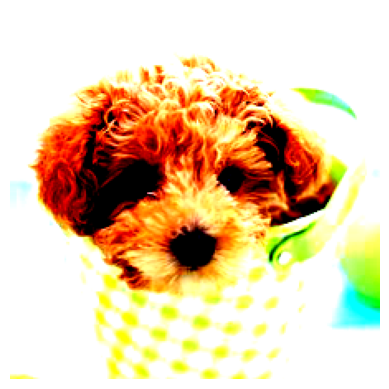

In [ ]:
resnet = ResNetForImageClassification(model, num_labels=2).to('cuda')
with torch.no_grad() :
    inputs['pixel_values'] = inputs['pixel_values'].to('cuda')
    outputs = resnet(inputs['pixel_values'], labels=torch.tensor([[1]]).to('cuda') )

# 시각화를 위해 데이터를 CPU로 이동합니다.
inputs['pixel_values'] = inputs['pixel_values'].to('cpu')
outputs['모델의 예측 확률'] = outputs['모델의 예측 확률'].to('cpu')
outputs['loss'] = outputs['loss'].to('cpu')
outputs['모델의 예측값']['id'] = outputs['모델의 예측값']['id'].to('cpu')

# 결과를 출력합니다.
print(f">> 입력 이미지의 형태 : {inputs['pixel_values'].shape}")
print(f">> 모델의 예측 확률 : {outputs['모델의 예측 확률']}")
print(f">> 모델의 예측 확률의 형태 : {outputs['모델의 예측 확률'].shape}")
print(f">> 모델의 예측 확률의 합 : {torch.sum(outputs['모델의 예측 확률'])}")
print(f">> 모델의 Loss 값 : {outputs['loss']}")
print(f">> 모델의 예측값 : {outputs['모델의 예측값']}")
print(f">> 입력 이미지 시각화 : ")
plt.imshow(inputs['pixel_values'][0].permute(1,2,0))
plt.axis('off')

del model, feature_extractor, resnet, inputs, outputs, original_image, preprocessed_image, last_hidden_states, train_dataset, test_dataset, config
torch.cuda.empty_cache()
gc.collect()

## 0-3. 관련 함수 정의

In [ ]:
def get_data(num_labeled = 32, num_unlabeled = 512) :
    dataset = load_dataset("sasha/dog-food")

    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    train_labeled_data = []
    train_unlabeled_data = []

    num_labeled_0 = 0
    num_labeled_1 = 0

    num_unlabeled_0 = 0
    num_unlabeled_1 = 0

    for img, label in zip(train_dataset['image'], train_dataset['label']) :
        if label == 0 and num_labeled_0 < num_labeled//2 : # 강아지 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_0 += 1
        elif label == 1 and num_labeled_1 < num_labeled//2 : # 음식 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_1 += 1
        elif label == 0 and num_unlabeled_0 < num_unlabeled//2 : # 강아지 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_0 += 1
        elif label == 1 and num_unlabeled_1 < num_unlabeled//2 : # 음식 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_1 += 1

        if (num_labeled_0 == num_labeled//2) and (num_labeled_1 == num_labeled//2) and (num_unlabeled_0 == num_unlabeled//2) and (num_unlabeled_1 == num_unlabeled//2) : # 모든 데이터를 뽑았다면 반복문을 종료합니다.
            break

    return train_labeled_data, train_unlabeled_data, test_dataset

# 1. Consistency Regularization
Consistency Regularization은 레이블이 있는 데이터에 대한 학습은 지속적으로 진행한다는 점에서 Self Train과 동일합니다.
다만, 레이블이 없는 데이터에 대해서는 동일한 데이터에 대해 여러가지 변형을 가했을 때, 예측이 변하면 안된다는 점을 이용한다는 점에서 차이가 있습니다.

## 2-1. Image Augmenatation
Consistency Regularization 중 Unsupervised Data Augmentation은 데이터에 대해 약간의 변형을 가합니다.
이러한 변화가 실제 이미지에서 어떠한 효과를 가져올 수 있는지 살펴보겠습니다.

![image.png](uda_1.jpg)

  0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 1.0, '데이터 증강 4회')

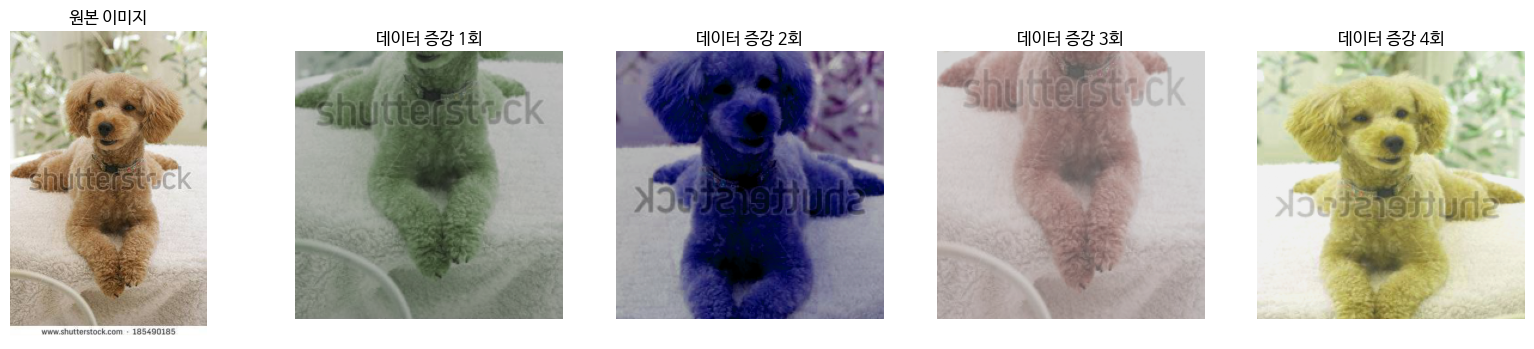

In [ ]:
_transform = Compose([ # _transrom 함수는 입력 이미지에 적용할 전처리 함수들을 모아놓은 함수입니다. 이미지는 Compose 내의 요소들을 순차적으로 통과하면서 변형이 가해지게 됩니다.
    RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    ToTensor(),
])

train_labeled_data, train_unlabeled_data, test_dataset = get_data(num_labeled = 32, num_unlabeled = 512)

## 데이터 증강 전후 예시 시각화
### plt 를 통해 (1, 5) 형태의 subplot을 생성합니다.
plt.figure(figsize=(20, 4))
plt.subplot(1,5,1, )
plt.imshow(train_labeled_data[0]['image'])
plt.axis('off')
plt.title("원본 이미지")
plt.subplot(1,5,2)
plt.imshow(_transform(train_labeled_data[0]['image']).permute(1,2,0))
plt.axis('off')
plt.title("데이터 증강 1회")
plt.subplot(1,5,3)
plt.imshow(_transform(train_labeled_data[0]['image']).permute(1,2,0))
plt.axis('off')
plt.title("데이터 증강 2회")
plt.subplot(1,5,4)
plt.imshow(_transform(train_labeled_data[0]['image']).permute(1,2,0))
plt.axis('off')
plt.title("데이터 증강 3회")
plt.subplot(1,5,5)
plt.imshow(_transform(train_labeled_data[0]['image']).permute(1,2,0))
plt.axis('off')
plt.title("데이터 증강 4회")

## 1-2. 학습 과정

UDA는 수업에서 다룬 바와 같이 1) 레이블이 있는 데이터에 대한 지도학습과 2) 레이블이 없는 데이터에 대해 Augmentation을 통한 비지도학습으로 구성되어 있습니다.

In [ ]:
class ImageLabeledDataset(torch.utils.data.Dataset) :
    def __init__(self, dataset, feature_extractor) :
        self.dataset = dataset # 학습 데이터셋을 해당 클래스 내부에 저장합니다.
        self.feature_extractor = feature_extractor # 이미지 데이터를 모델 입력으로 변환해주는 feature_extractor를 저장합니다.

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) : # 해당 메소드는 인덱스를 입력으로 받아 해당 인덱스에 위치한 데이터를 반환합니다.
        image = self.dataset[idx]['image'] # 해당 인덱스에 위치한 이미지를 불러옵니다.
        label = self.dataset[idx]['label'] # 해당 인덱스에 위치한 레이블을 불러옵니다.

        inputs = self.feature_extractor(images=image, return_tensors="pt") # 모델이 입력으로 받을 수 있는 Pytorch Tensor 형태로 변환합니다.
        inputs['pixel_values'] = inputs['pixel_values'].squeeze() # 해당 이미지의 차원을 (RGB 채널, 이미지 높이, 이미지 너비)로 변경합니다.
        inputs['labels'] = torch.tensor(label) # Loss 계산을 위해 레이블을 추가합니다.
        inputs['idx'] = torch.tensor(idx) # 향후 분석을 위해 인덱스를 추가합니다.

        return inputs

class ImageUnlabeledDataset(torch.utils.data.Dataset) : # 레이블이 없는 데이터셋을 이용하기 위한 클래스를 정의합니다.
    def __init__(self, dataset, feature_extractor) :
        self.dataset = dataset # 학습 데이터셋을 해당 클래스 내부에 저장합니다.
        self.feature_extractor = feature_extractor # 이미지 데이터를 모델 입력으로 변환해주는 feature_extractor를 저장합니다. 해당 실험에서는 FeatureExtractor를 약한 증강으로 사용하겠습니다.
        self._transform = Compose([ # 강한 데이터 증강을 위한 Compose를 정의합니다.
            RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
            ToTensor()
        ])

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) : # 해당 메소드는 인덱스를 입력으로 받아 해당 인덱스에 위치한 데이터를 반환합니다.
        image = self.dataset[idx]['image'] # 해당 인덱스에 위치한 이미지를 불러옵니다.
        label = self.dataset[idx]['label'] # 해당 인덱스에 위치한 레이블을 불러옵니다.

        weakly_augmented_image = self.feature_extractor(images = image, return_tensors = 'pt')['pixel_values'].squeeze() # 약하게 증강된 이미지를 불러옵니다.
        strongly_augmented_image = self._transform(image) # 강하게 증강된 이미지를 불러옵니다.

        return {
            'weakly_augmented_image' : weakly_augmented_image,
            'strongly_augmented_image' : strongly_augmented_image,
            'label' : label,
            'idx' : idx
        }

In [ ]:
def get_dataloader(dataset, feature_extractor, batch_size, shuffle, labeled = True) : # 데이터셋을 DataLoader 형태로 변환해주는 함수를 정의합니다.
    if labeled :
        dataset = ImageLabeledDataset(dataset, feature_extractor) # 데이터셋을 ImageLabeledDataset 형태로 변환합니다.
    else :
        dataset = ImageUnlabeledDataset(dataset, feature_extractor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle) # 데이터셋을 DataLoader 형태로 변환합니다.

    return dataloader

### 1-2-1. Dataloader
UDA는 레이블이 존재하는 데이터와 존재하지 않는 데이터를 별도로 처리합니다.
이때, 레이블이 없는 데이터도 함께 학습 과정에서 입력되게 됩니다.
주의할 점은 레이블이 있는 데이터와 없는 데이터가 다른 배치 크기를 가질 수 있습니다.
아래 예시는 다음과 같은 배치 크기를 가지도록 설계되어 있습니다.

- 레이블이 있는 이미지의 수 : 4
- 레이블이 없는 이미지의 수 : 64

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
labeled_dataloader = get_dataloader(train_labeled_data, feature_extractor, batch_size = 4, shuffle = True, labeled = True) # 레이블이 있는 데이터셋을 위한 DataLoader를 생성합니다.
unlabeled_dataloader = get_dataloader(train_unlabeled_data, feature_extractor, batch_size = 4, shuffle = True, labeled = False) # 레이블이 없는 데이터셋을 위한 DataLoader를 생성합니다.

# 두 데이터의 배치 별 형태를 확인합니다.
for batch in labeled_dataloader :
    print('-'*10, '레이블이 존재하는 데이터', '-'*10)
    print(f">>> 배치 크기 : {batch['pixel_values'].shape}")
    print(f">>> 레이블 : {batch['labels']}")
    break

for batch in unlabeled_dataloader :
    print('-'*10, '레이블이 존재하지 않는 데이터', '-'*10)
    print(f">>> 배치 크기 : {batch['weakly_augmented_image'].shape}, {batch['strongly_augmented_image'].shape}")
    print(f">>> 레이블 : {batch['label']}")
    break

---------- 레이블이 존재하는 데이터 ----------
>>> 배치 크기 : torch.Size([4, 3, 224, 224])
>>> 레이블 : tensor([1, 1, 1, 0])
---------- 레이블이 존재하지 않는 데이터 ----------
>>> 배치 크기 : torch.Size([4, 3, 224, 224]), torch.Size([4, 3, 224, 224])
>>> 레이블 : tensor([0, 0, 0, 1])


### 1-2-2. 학습 과정
UDA의 학습 과정은 다음과 같은 순서로 진행됩니다.

1. 각 배치는 레이블이 존재하는 데이터와 존재하지 않는 데이터로 구성되어 있다.
2. 레이블이 존재하는 데이터에 대해서는 지도학습 방법론을 사용하여 Supervised Cross Entropy Loss를 계산하게 된다. (Sup Loss)
3. 레이블이 존재하지 않는 데이터에 대해서는 강하게 증강된 데이터와 약하게 증강된 데이터 간의 Unsupervised Consistency Loss를 계산하게 된다. (Unsup Loss)
4. 두 Loss를 합하여 최종 손실함수로 학습이 진행된다.

이때 Unsupervised Loss는 아래와 같이 증강에 따른 동일 데이터의 예측 확률분포를 이용하게 됩니다.

<img src="./uda_2.png" width="900">

In [ ]:
def get_unsup_loss(weak_unlabel_logit, strong_unlabeled_logit, temperature = 1) :
    unsup_target = torch.softmax(weak_unlabel_logit/temperature, dim=-1) # 약하게 증강된 데이터에 대해 확률분포를 구합니다.
    loss = -(unsup_target * torch.log_softmax(strong_unlabeled_logit, dim=-1)).sum(dim=-1).mean() # 약하게 증강된 데이터에 대해 가장 높은 확률을 가진 클래스가 threshold 보다 높은 데이터에 대해서만 loss를 계산합니다.
    return loss # loss를 반환합니다.

위와 같은 과정으로 Unsupervised Loss가 계산되는 과정을 예시를 통해 살펴보면 다음과 같습니다.

![image.png](./uda_3.png)

In [ ]:
weak_unlabel_logit = torch.randn(4, 2) # 약하게 증강된 데이터에 대한 모델의 출력값입니다. 10개 데이터에 대해 2개의 클래스에 대한 확률분포를 가지고 있습니다.
strong_unlabeled_logit = torch.randn(4, 2) # 강하게 증강된 데이터에 대한 모델의 출력값입니다. 10개 데이터에 대해 2개의 클래스에 대한 확률분포를 가지고 있습니다.

unsup_target = torch.softmax(weak_unlabel_logit, dim=-1) # 약하게 증강된 데이터에 대해 확률분포를 구합니다.
loss = -(unsup_target * torch.log_softmax(strong_unlabeled_logit, dim=-1)).sum(dim=-1).mean() # 약하게 증강된 데이터를 통해 산출된 예측 분포를 target으로 강하게 증강된 데이터를 통해 학습이 진행됩니다.

print(f"Shape of weak_unlabel_logit : {weak_unlabel_logit.shape}")
print(f"Shape of strong_unlabeled_logit : {strong_unlabeled_logit.shape}")

print(f"unsup_target : {unsup_target}")
print(f"loss : {loss}")

# 출력값을 확인해보면 unsup_target이 확률분포를 띄고 있고, 높은 확률이 0.55(threshold)를 넘을 경우에만 mask가 1의 값을 가지고 있습니다. 따라서 loss는 확률값이 높은 클래스에 대해서만 계산되고, 이를 평균한 값이 반환됩니다.

Shape of weak_unlabel_logit : torch.Size([4, 2])
Shape of strong_unlabeled_logit : torch.Size([4, 2])
unsup_target : tensor([[0.4800, 0.5200],
        [0.8028, 0.1972],
        [0.6244, 0.3756],
        [0.5033, 0.4967]])
loss : 0.8149622082710266


In [ ]:
def plot_pred(unlabeled_dataset, unlabeled_batch, weak_logit, strong_logit, title = None) :
    """
    입력된 데이터 중 랜덤한 4개의 예측 결과를 시각화하는 함수입니다.
    """
    num_vis = 4
    rand = np.random.choice(len(unlabeled_batch['idx']), num_vis, replace = False)
    batch_idx = unlabeled_batch['idx'][rand]
    print(batch_idx)
    vis_original_data = [unlabeled_dataset[idx] for idx in batch_idx]
    vis_weak_img = unlabeled_batch['weakly_augmented_image'][rand]
    vis_strong_img = unlabeled_batch['strongly_augmented_image'][rand]
    vis_weak_logit = weak_logit[rand]
    vis_strong_logit = strong_logit[rand]

    fig, axes = plt.subplots(3, 4, figsize = (20, 10))

    for idx in range(num_vis):
        axes[0, idx].imshow(vis_original_data[idx]['image'])
        axes[0, idx].set_title(f"Original Image")
        axes[0, idx].axis('off')

        axes[1, idx].imshow(vis_weak_img[idx].cpu().permute(1,2,0))
        axes[1, idx].set_title(f"약하게 증강된 데이터의 예측 분포 : {[round(logit, 4) for logit in vis_weak_logit[idx].cpu().tolist()]}")
        axes[1, idx].axis('off')

        axes[2, idx].imshow(vis_strong_img[idx].cpu().squeeze().permute(1,2,0))
        axes[2, idx].set_title(f"강하게 증강된 데이터의 예측 분포 : {[round(logit, 4) for logit in vis_strong_logit[idx].cpu().tolist()]}")
        axes[2, idx].axis('off')

        # plt.subplot(3, 4, idx+1)
        # plt.imshow(vis_original_data[idx]['image'])
        # plt.axis('off')
        # # make subtitle
        # plt.subtitle("원본 이미지")
        # plt.subplot(3, 4, idx+5)
        # plt.imshow(vis_weak_img[idx])
        # plt.axis('off')
        # plt.subtitle(f"약하게 증강된 데이터의 예측 분포 : {np.argmax(vis_weak_logit[idx])}")
        # plt.subplot(3, 4, idx+9)
        # plt.imshow(vis_strong_img[idx])
        # plt.axis('off')
        # plt.subtitle(f"강하게 증강된 데이터의 예측 분포 : {np.argmax(vis_strong_logit[idx])}")


    if title is not None :
        fig.set_tight_layout(True)
        fig.suptitle(title)
    plt.show()

In [ ]:
# 모델을 선언합니다.
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
config = AutoConfig.from_pretrained("microsoft/resnet-50")
resnet = AutoModel.from_config(config)
model = ResNetForImageClassification(resnet, num_labels=2).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 데이터를 불러옵니다.
train_labeled_data, train_unlabeled_data, test_dataset = get_data(num_labeled=8, num_unlabeled=256)
train_labeled_dataloader = get_dataloader(train_labeled_data, feature_extractor, batch_size = 4, shuffle = True, labeled = True) # 레이블이 있는 데이터셋을 위한 DataLoader를 생성합니다.
train_unlabeled_dataloader = get_dataloader(train_unlabeled_data, feature_extractor, batch_size = 32, shuffle = True, labeled = False) # 레이블이 없는 데이터셋을 위한 DataLoader를 생성합니다.
test_dataloader = get_dataloader(test_dataset, feature_extractor, batch_size = 128, shuffle = False, labeled = True) # 레이블이 있는 데이터셋을 위한 DataLoader를 생성합니다.
# 학습 관련 하이퍼 파라미터를 선언합니다.

log_interval = 10
max_epoch = 15
iteration = 0

epoch = 0
while epoch < max_epoch:
    epoch += 1
    for labeled_data, unlabeled_data in zip(train_labeled_dataloader, unlabeled_dataloader) :
        # 0. 모든 데이터를 gpu로 옮깁니다.
        labeled_data = {key: value.to('cuda') for key, value in labeled_data.items()}
        unlabeled_data = {key: value.to('cuda') for key, value in unlabeled_data.items()}
        # 1. 레이블이 있는 데이터를 이용해 Labeled Loss를 계산합니다.
        sup_loss = model(pixel_values = labeled_data['pixel_values'], labels = labeled_data['labels'])['loss']

        # 2. 레이블이 없는 데이터를 이용해 Unlabeled Loss를 계산합니다.
        weak_unlabel_logit = model(pixel_values = unlabeled_data['weakly_augmented_image'])['logits']
        strong_unlabeled_logit = model(pixel_values = unlabeled_data['strongly_augmented_image'])['logits']
        ## 2-1. Unlabeled Loss는 약하게 증강된 데이터에 대해 가장 높은 확률을 가진 클래스가 threshold 보다 높은 데이터에 대해서만 loss를 계산합니다.
        unsup_loss = get_unsup_loss(weak_unlabel_logit, strong_unlabeled_logit, temperature = 1)

        loss = sup_loss + unsup_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration += 1

        if iteration % log_interval == 0 :
            print(f"Epoch : {epoch} | iteration : {iteration:3d}, sup_loss : {sup_loss.item():.5f}, unsup_loss : {unsup_loss.item():.5f}")
            plot_pred(unlabeled_dataloader.dataset.dataset, unlabeled_data, weak_unlabel_logit, strong_unlabeled_logit, title = f"Epoch : {epoch} | iteration : {iteration:3d}, sup_loss : {sup_loss.item():.5f}, unsup_loss : {unsup_loss.item():.5f}")

Output hidden; open in https://colab.research.google.com to view.

## 1-3. 학습과정 함수화

위 실습을 통해 살펴본 전체 학습과정을 함수화하여 실험을 진행해보도록 하겠습니다.

In [ ]:
def test(test_dataloader, model) :
    """
    테스트 데이터셋을 이용해 모델의 성능을 평가하는 함수입니다.
    """
    model.eval()
    correct = 0
    with torch.no_grad() :
        for data in test_dataloader :
            data = {key: value.to('cuda') for key, value in data.items()}
            output = model(pixel_values = data['pixel_values'])
            pred = output['logits'].argmax(dim=-1)
            correct += (pred == data['labels']).sum().item()
    print(f">> Test Accuracy : {correct / len(test_dataset)}")
    model.train()
    return correct / len(test_dataset)

def train_uda(num_labeled, num_unlabeled, labeled_bsz, unlabeled_bsz, epoch, beta = 1, log_interval = 10) :
    feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
    config = AutoConfig.from_pretrained("microsoft/resnet-50")
    resnet = AutoModel.from_config(config)
    model = ResNetForImageClassification(resnet, num_labels=2).to('cuda')
    optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

    train_labeled_data, train_unlabeled_data, test_dataset = get_data(num_labeled=num_labeled, num_unlabeled=num_unlabeled)
    train_labeled_dataloader = get_dataloader(train_labeled_data, feature_extractor, batch_size = labeled_bsz, shuffle = True, labeled = True) # 레이블이 있는 데이터셋을 위한 DataLoader를 생성합니다.
    train_unlabeled_dataloader = get_dataloader(train_unlabeled_data, feature_extractor, batch_size = unlabeled_bsz, shuffle = True, labeled = False) # 레이블이 없는 데이터셋을 위한 DataLoader를 생성합니다.
    test_dataloader = get_dataloader(test_dataset, feature_extractor, batch_size = 128, shuffle = False, labeled = True) # 레이블이 있는 데이터셋을 위한 DataLoader를 생성합니다.

    iteration = 0
    sup_loss_list = []
    unsup_loss_list = []
    test_result_list = []

    for epoch in range(epoch) :
        for labeled_data, unlabeled_data in zip(train_labeled_dataloader, train_unlabeled_dataloader) :
            # 0. 모든 데이터를 gpu로 옮깁니다.
            labeled_data = {key: value.to('cuda') for key, value in labeled_data.items()}
            unlabeled_data = {key: value.to('cuda') for key, value in unlabeled_data.items()}
            # 1. 레이블이 있는 데이터를 이용해 Labeled Loss를 계산합니다.
            sup_loss = model(pixel_values = labeled_data['pixel_values'], labels = labeled_data['labels'])['loss']

            # 2. 레이블이 없는 데이터를 이용해 Unlabeled Loss를 계산합니다.
            weak_unlabel_logit = model(pixel_values = unlabeled_data['weakly_augmented_image'])['logits']
            strong_unlabeled_logit = model(pixel_values = unlabeled_data['strongly_augmented_image'])['logits']
            ## 2-1. Unlabeled Loss는 약하게 증강된 데이터에 대해 가장 높은 확률을 가진 클래스가 threshold 보다 높은 데이터에 대해서만 loss를 계산합니다.
            unsup_loss = get_unsup_loss(weak_unlabel_logit, strong_unlabeled_logit, temperature = 1)

            loss = sup_loss + beta*unsup_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            iteration += 1

            sup_loss_list.append(sup_loss.item())
            unsup_loss_list.append(unsup_loss.item())

            if iteration % log_interval == 0 :
                print(f"Epoch : {epoch} | iteration : {iteration:3d}, sup_loss : {sup_loss.item():.5f}, unsup_loss : {unsup_loss.item():.5f}")
                plot_pred(train_unlabeled_dataloader.dataset.dataset, unlabeled_data, weak_unlabel_logit, strong_unlabeled_logit, title = f"Epoch : {epoch} | iteration : {iteration:3d}")

            if iteration % 20 == 0 :
                test_result_list.append(test(test_dataloader, model))
    test_result_list.append(test(test_dataloader, model))

    del model, optimizer, train_labeled_data, train_unlabeled_data, test_dataset, train_labeled_dataloader, train_unlabeled_dataloader, test_dataloader
    torch.cuda.empty_cache()
    gc.collect()

    return sup_loss_list, unsup_loss_list, test_result_list

In [ ]:
## 단순히 위에서 정의한 함수를 실행하면 아래와 같은 결과를 얻을 수 있습니다.
sup_loss_list, unsup_loss_list, test_result_list = train_uda(num_labeled=16, num_unlabeled=256, labeled_bsz=4, unlabeled_bsz=16, beta=1, epoch=10, log_interval = 10)

Output hidden; open in https://colab.research.google.com to view.

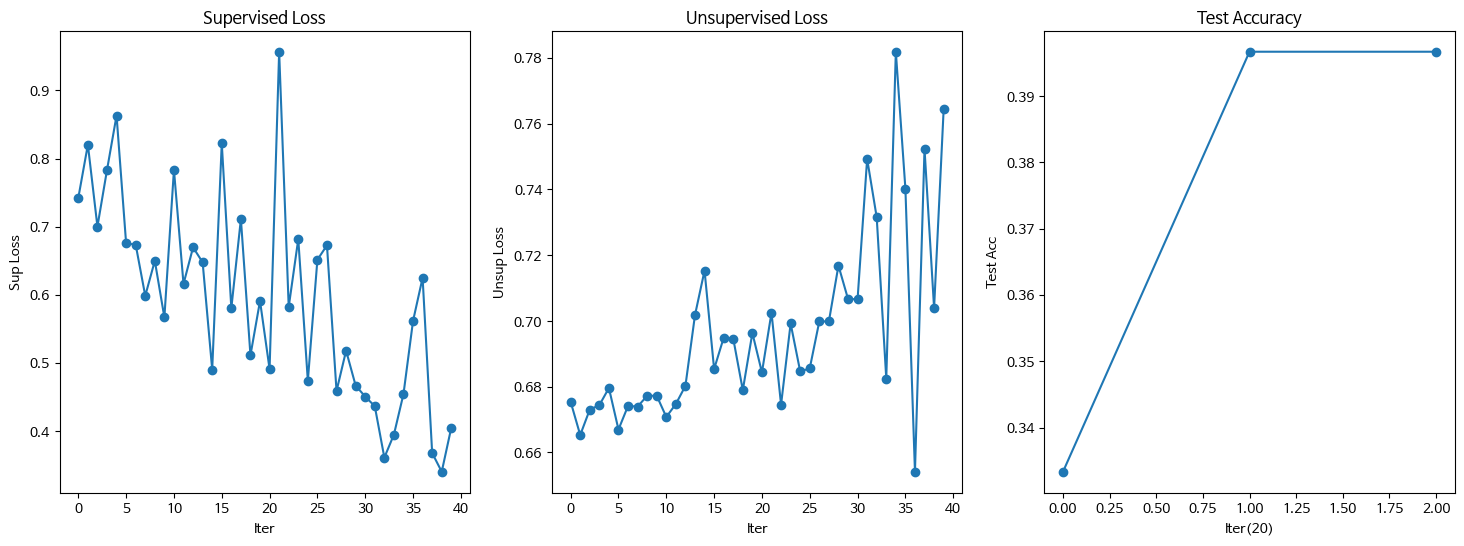

In [ ]:
## Self Train 반복에 따른 레이블링된 데이터 수 및 정확도, F1 Score 변화를 line plot으로 시각화합니다.
def visualize_result(sup_loss_list, unsup_loss_list, test_acc_list) :

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(sup_loss_list, label="Supervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Sup Loss")
    plt.title("Supervised Loss")


    plt.subplot(1, 3, 2)
    plt.plot(unsup_loss_list, label="Unsupervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Unsup Loss")
    plt.title("Unsupervised Loss")

    plt.subplot(1, 3, 3)
    plt.plot(test_acc_list, label="Test Accuracy", marker = "o")
    plt.xlabel('Iter(20)')
    plt.ylabel('Test Acc')
    plt.title("Test Accuracy")
    plt.show()

visualize_result(sup_loss_list, unsup_loss_list, test_result_list)

In [ ]:
## 레이블이 없는 데이터에 비중을 높혀 학습시켜 보겠습니다.
sup_loss_list, unsup_loss_list, test_result_list = train_uda(num_labeled=16, num_unlabeled=256, labeled_bsz=4, unlabeled_bsz=16, beta=5, epoch=10, log_interval = 10)
visualize_result(sup_loss_list, unsup_loss_list, test_result_list)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## 레이블이 없는 데이터에 비중을 낮추어 학습시켜 보겠습니다.
sup_loss_list, unsup_loss_list, test_result_list = train_uda(num_labeled=16, num_unlabeled=256, labeled_bsz=4, unlabeled_bsz=16, beta=0.5, epoch=10, log_interval = 10)
visualize_result(sup_loss_list, unsup_loss_list, test_result_list)ㅋ

Output hidden; open in https://colab.research.google.com to view.